# Q1. Predicting housing prices

In this problem, you will generate models for predicting house prices from given house features. The file “house_prices.txt” contains the data.

There are four features used in this regression:

* one binary feature (whether or not the house has covered parking)
* one numerical feature (size, measure in thousands of square meters)
* two categorical features (architectural style and location)

Each of the categorial features is represented as a vector of size 3. This gives us feature vectors of size 8 in total for each house. 200 examples are given in the training set.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = pathlib.Path("./datasets")#you may need to change this to find the data

In [3]:
features = pd.read_csv(
    DATA_DIR / "house_prices.txt",
    delimiter = "\t",
    skiprows=[0, 1, 2, 3, 4],
    header=None,
    usecols=[0, 1, 2, 3, 4, 6, 7, 8],
    names=["parking", "sq_meters", "art_deco", "bungalow", "colonial", "west", "east", "north"],
    dtype=np.float32
)

target = pd.read_csv(
    DATA_DIR / "house_prices.txt",
    delimiter = "\t",
    skiprows=[0, 1, 2, 3, 4],
    header=None,
    usecols=[5],
    names=["price"],
    dtype=np.float32
)


In [4]:
features.head()

,parking,sq_meters,art_deco,bungalow,colonial,west,east,north
0,-1.0,0.1275,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.1100,1.0,0.0,0.0,1.0,0.0,0.0
2,-1.0,0.1375,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.1975,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.0,0.1200,0.0,0.0,1.0,1.0,0.0,0.0


## a) Split the dataset into training and testing sets

Split the dataset into training and testing sets. Keep 80% of the data for training and 20% of the data for testing.

In [5]:
# Print sizes
print(features.shape)
print(target.shape)

# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# Split feature
X_train, X_test, y_train, y_test = (
    features.iloc[train_idx],
    features.iloc[test_idx],
    target.iloc[train_idx],
    target.iloc[test_idx]
)

(200, 8)
(200, 1)


## b) Build a neural network to predict house prices

Since we do not use pytorch to build a neural network, I don't want to use pytorch to import the data. Instead, I use pandas to import the data and then convert it to numpy array, which had been done in the previous cell.

Here I define the basic components of a neural network, including the activation function, the loss function, and the forward and backward propagation.

I want to realize the NN like pytorch or tensorflow, so I define a class for each component. Each type of layer is a class, storing the parameters and the gradients. The forward and backward propagation are also defined in the class.

When training, I only need to call the forward and backward functions of each layer in order. When testing, I only need to call the forward function of each layer in order.

In [6]:
class Linear:
    """
    X input size: (batch, p)
    """
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.W = np.random.randn(in_features, out_features)
        self.b = np.random.randn(out_features)
        # forward: Z (batch, out_features) <- X (batch, in_features) * W (in_features, out_features) + b (out_features)
        self.grad_W = None
        self.grad_b = None
        self.X = None
        self.batchSize = None

    def forward(self, X):
        self.X = X
        self.batchSize = X.shape[0]
        Z = np.dot(X, self.W) + self.b
        return Z

    def backward(self, dZ):
        # dZ (batch, out_features)
        # dW (in_features, out_f) <- X.T (in_features, batch) * dZ (batch, out_features)
        self.grad_W = np.dot(self.X.T, dZ)
        self.grad_b = np.sum(dZ, axis=0)
        dX = np.dot(dZ, self.W.T)
        return dX

    def update(self, lr):
        self.W -= lr * self.grad_W
        self.b -= lr * self.grad_b
        self.grad_W = None
        self.grad_b = None

class ReLU:
    def __init__(self):
        self.Z = None

    def forward(self, X):
        self.Z = np.maximum(X, 0)
        return self.Z

    def backward(self, dZ):
        dX = dZ * (self.Z > 0)
        return dX

class Sigmoid:
    def __init__(self):
        self.Z = None

    def forward(self, X):
        self.Z = 1/(1 + np.exp(-X))
        return self.Z

    def backward(self, dZ):
        dX = dZ * self.Z * (1 - self.Z)
        return dX

class sigmoidCrossEntropy:
    def __init__(self):
        self.y = None
        self.y_hat = None

    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = 1/(1 + np.exp(-y_hat))
        return -np.mean(y * np.log(self.y_hat) + (1 - y) * np.log(1 - self.y_hat))

    def backward(self):
        return (self.y_hat - self.y)/self.y.shape[0]

class MeanSquaredError:
    def __init__(self):
        self.y = None
        self.y_hat = None

    def forward(self, y_hat, y):
        self.y = y
        self.y_hat = y_hat
        return np.mean((y - y_hat)**2)

    def backward(self):
        return 2*(self.y_hat - self.y)/self.y.shape[0]

class SoftmaxCrossEntropy:
    def __init__(self):
        self.y = None
        self.y_hat = None

    def forward(self, z, y):
        self.y = y
        self.y_hat = np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True) # along the row
        return -np.mean(np.sum(y * np.log(self.y_hat), axis=1))

    def backward(self):
        return (self.y_hat - self.y)/self.y.shape[0]

    def accuracy(self):
        return np.mean(np.argmax(self.y_hat, axis=1) == np.argmax(self.y, axis=1))
    def predict(self):
        return np.argmax(self.y_hat, axis=1)

## c) Train your neural network using gradient descent

Using mean square loss, train the network with an appropriate optimizer for a few hundred epochs and plot the loss versus the number of training epochs.

Here I simply used mini-batch gradient descent to train the network. More advanced optimizers like Adam or RMSProp can be used later.

In [7]:
# define a iterator to output batches
def batch_iterator(X, y, batch_size):
    # shuffle the data
    X, y = X.copy(), y.copy()
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X, y = X[idx], y[idx]
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    for i in range(num_batches):
        start = i * batch_size
        end = (i+1) * batch_size
        yield X[start:end], y[start:end]

In [8]:
#setting hyperparameters
batch_size = 20
lr = 1e-2
epochs = 200

Ensemble the layers and train the network.

0.2858670366192969
0.3192766618488315
0.22783607139214235
0.2241022321887594
0.16535474247802323
0.18817840104710318
0.13176182683310508
0.1397485754644397
0.11136413240739193
0.10985493475499233
0.0927227241650094
0.09297506753227369
0.08031998302927025
0.07991572545948851
0.0710369527198078
0.0700974831363512
0.06423895760430909
0.06050239440425846
0.058469124294105154
0.054330355514638565
0.05316020920888914
0.05077535478864671
0.05021446016904284
0.045058266146536366
0.046031490685051676
0.04555919603661955
0.04259209141000164
0.039823928734177706
0.04016347175121017
0.036807203975124755
0.03787306651922932
0.036271562346321805
0.036003821585385905
0.031766137624769805
0.03406662383302798
0.03211644972967385
0.03272444891945325
0.02892807474774876
0.030867281232432247
0.02865156474543069
0.030628452384281635
0.026149100611541982
0.028296355882047524
0.025600554316718094
0.02738447707169837
0.02402746071296209
0.026203070146716745
0.02404816205689502
0.026481912134154566
0.022570538

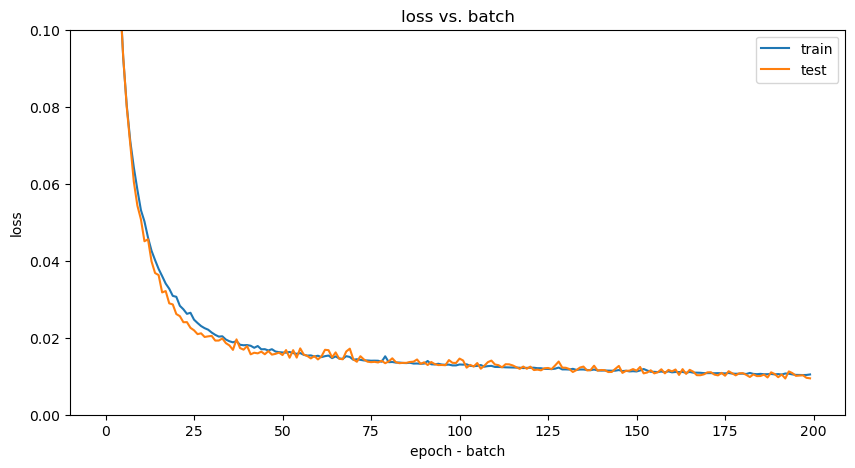

In [9]:
# build the network
losses = []
losses_test = []
model_reg = [
    Linear(8,10),
    ReLU(),
    Linear(10, 10),
    ReLU(),
    Linear(10, 1),
]
loss = MeanSquaredError()
# train the network
loss_val = np.var(y_train.values)# initialize the loss by the variance of the training data
for epoch in range(epochs):
    iterator = batch_iterator(X_train.values, y_train.values, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in model_reg:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in model_reg[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in model_reg:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    # print(f'epoch {epoch}, loss {loss_val}')
    X = X_train.values
    for layer in model_reg:
        X = layer.forward(X)
    loss_val = loss.forward(X,y_train.values)
    losses.append(loss_val)
    print(loss_val)
    X = X_test.values
    for layer in model_reg:
        X = layer.forward(X)
    loss_val_test = loss.forward(X,y_test.values)
    losses_test.append(loss_val_test)
    print(loss_val_test)


plt.figure(figsize=(10, 5))
plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.xlabel('epoch - batch')
plt.ylabel('loss')
plt.title('loss vs. batch')
plt.legend()
plt.ylim(0, 0.1)
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(losses)
# plt.xlabel('epoch - batch')
# plt.ylabel('loss')
# plt.title('loss vs. batch')
# plt.ylim(0, 0.1)
# plt.show()

## d) Assess the performance of your neural network

Assess the performance of your neural network on the training data and the testing data. Comment on the results.

#### Some comments
- The loss is decreasing as the number of epochs increases, which is a good sign. Our model is learning.
- We don't need to train too many epochs, since the loss is already small enough.
- Let's see how the model performs on the test set.

However, if we look closely at the training loss, we still find it fluctuates a lot. A adaptive learning rate can be used to improve the performance. However, this may also cause the model to overfit the training data. **So I will try it after question d).**

In [10]:
# test the model
X = X_test.values
for layer in model_reg:
    X = layer.forward(X)
loss_val = loss.forward(y_test.values, X)
print(f'test loss {loss_val}')

test loss 0.0094548101517037


This result is pretty good. The loss on the test set is not much larger than the loss on the training set. This means that our model is not overfitting.

## e) adaptive learning rate

In [11]:
# set a scheduler to adjust the learning rate
## This is a simple decay scheduler
class Scheduler:
    def __init__(self, lr, decay):
        self.lr = lr
        self.decay = decay

    def learning_rate(self, e):
        return self.lr * self.decay**e

0.32256870649792135
0.23905850178660537
0.17350629071798498
0.14467927904367076
0.12470101205421699
0.11708576938835091
0.10112960224360719
0.10504421050900317
0.08696115777705728
0.09686623692722689
0.07693847144422583
0.08979283540719743
0.06980989784328692
0.08266420165986041
0.06465547371808786
0.07802426192851213
0.06028609914615039
0.0740242214672165
0.05675727928116457
0.06945993346416154
0.0537578156664831
0.06611682699345645
0.0510633594916704
0.06304925383935944
0.04883881672627016
0.060143120300135425
0.046606612737838296
0.058140278712359716
0.04450996337472516
0.05485683743911761
0.043094681113859126
0.05374639447513132
0.04155429875034816
0.051861759990432334
0.04014353510897364
0.04930317632761947
0.0391031974389656
0.048948788148660424
0.03779846621564069
0.04617749126900961
0.037105929255762914
0.0447200699767443
0.03593864830421001
0.04330208339483991
0.03544233806845515
0.044180088820101646
0.03428618926006619
0.0426113241514652
0.03323501246838242
0.0404717043939271

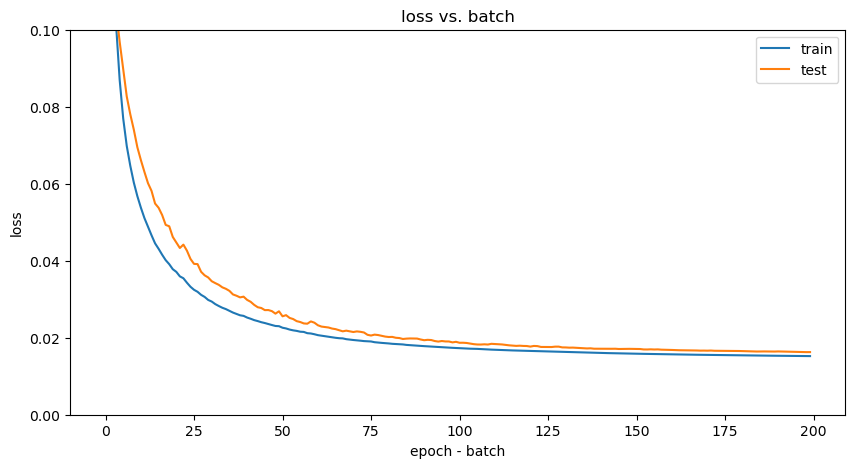

In [12]:
# build the network
model_reg = [
    Linear(8,10),
    ReLU(),
    Linear(10, 10),
    ReLU(),
    Linear(10, 1),
]
loss = MeanSquaredError()

#setting hyperparameters
batch_size = 20
lr = 1e-2
epochs = 200
losses = []
losses_test = []
scheduler = Scheduler(lr, 0.99)
# train the network
loss_val = np.var(y_train.values)# initialize the loss by the variance of the training data
for epoch in range(epochs):
    iterator = batch_iterator(X_train.values, y_train.values, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in model_reg:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in model_reg[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in model_reg:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(scheduler.learning_rate(epoch))
    # print(f'epoch {epoch}, loss {loss_val}')
    X = X_train.values
    for layer in model_reg:
        X = layer.forward(X)
    loss_val = loss.forward(X,y_train.values)
    losses.append(loss_val)
    print(loss_val)
    X = X_test.values
    for layer in model_reg:
        X = layer.forward(X)
    loss_val_test = loss.forward(X,y_test.values)
    losses_test.append(loss_val_test)
    print(loss_val_test)


plt.figure(figsize=(10, 5))
plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.xlabel('epoch - batch')
plt.ylabel('loss')
plt.title('loss vs. batch')
plt.legend()
plt.ylim(0, 0.1)
plt.show()

In [13]:
# test the model
X = X_test.values
for layer in model_reg:
    X = layer.forward(X)
loss_val = loss.forward(y_test.values, X)
print(f'test loss {loss_val}')

test loss 0.016265379845210808


Sadly, the adaptive learning rate does not improve the performance of the model. The loss is still fluctuating a lot, and the loss on the test set is even larger than the loss on the training set. This means that the model is overfitting the training data.

# Q2. Classification

Consider the following simulated classification dataset with N = 300 samples labeled with one of three class labels.

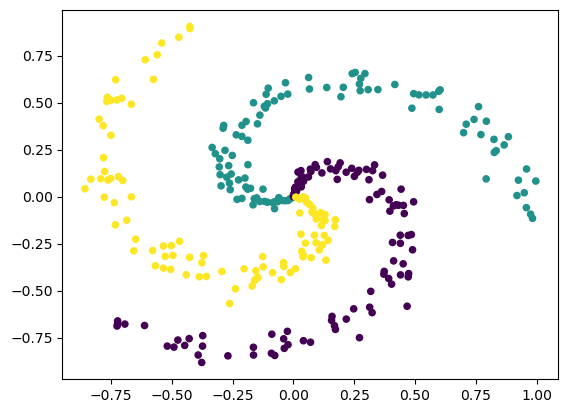

In [14]:
features = (np.load(DATA_DIR / "spiral_features.npy")
              .astype(np.float32))
target = np.load(DATA_DIR / "spiral_target.npy")

# visualize the data
plt.scatter(features[:, 0], features[:, 1], c=target, s=20)
plt.show()

## a) Split the dataset into training and testing sets

Split the dataset into training and testing sets. Keep 80% of the data for training and 20% of the data for testing.

In [15]:
# Print sizes
print(features.shape)
print(target.shape)

# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# to one-hot
y = np.eye(3)[target.astype(np.int8)] #this is so elegant!!!!

# Split feature
X_train, X_test, y_train, y_test = (
    features[train_idx],
    features[test_idx],
    y[train_idx],
    y[test_idx]
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(300, 2)
(300,)
(240, 2)
(60, 2)
(240, 3)
(60, 3)


## b) Train a logistic regression model

Not using Pytorch here. Load the dataset, and train a logistic regression for multi-class classification. Use the softmax function as the activation function.

#### The Logistic Regression for multi-class classification is equivalent to the a fully connected neural network with softmax activation function.

Let's see why the two are equivalent. The logistic regression model out put a vector $z$ with three elements, and the softmax function is defined as
$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^3 e^{z_j}}
$$
where $i = 1, 2, 3$. The output of the softmax function is a vector with three elements, and the sum of the elements is 1. This is exactly the same as the output of the logistic regression model. So the logistic regression model is equivalent to a fully connected neural network with softmax activation function.

Now we can easily build the logistic regression model via the neural network framework defined in question 1.

epoch 0, accuracy 0.3125
epoch 10, accuracy 0.3541666666666667
epoch 20, accuracy 0.42083333333333334
epoch 30, accuracy 0.475
epoch 40, accuracy 0.48333333333333334
epoch 50, accuracy 0.5
epoch 60, accuracy 0.525
epoch 70, accuracy 0.5041666666666667
epoch 80, accuracy 0.49166666666666664
epoch 90, accuracy 0.49166666666666664
epoch 100, accuracy 0.4875
epoch 110, accuracy 0.4875
epoch 120, accuracy 0.4875
epoch 130, accuracy 0.49166666666666664
epoch 140, accuracy 0.5
epoch 150, accuracy 0.5083333333333333
epoch 160, accuracy 0.5083333333333333
epoch 170, accuracy 0.5083333333333333
epoch 180, accuracy 0.5083333333333333
epoch 190, accuracy 0.5083333333333333


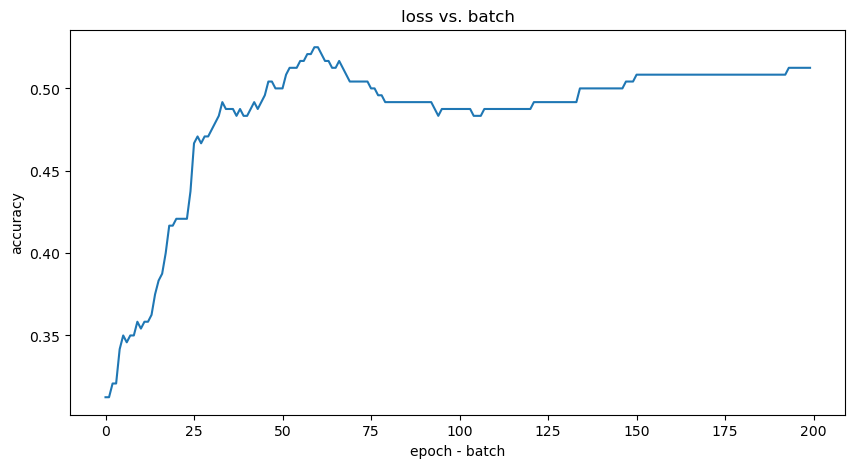

In [16]:
# build the network
logi_reg = [
    Linear(2, 3),
]
loss = SoftmaxCrossEntropy()

#setting hyperparameters
batch_size = 60
lr = 1e-1
epochs = 200
losses = []
# train the network
loss_val = np.var(y_train)# initialize the loss by the variance of the training data

for epoch in range(epochs):
    iterator = batch_iterator(X_train, y_train, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in logi_reg:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in logi_reg[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in logi_reg:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    #print(f'epoch {epoch}, loss {loss_val}')
    # calculate the accuracy on the training set
    X_train_e = X_train
    for layer in logi_reg:
        X_train_e = layer.forward(X_train_e)
    loss_val = loss.forward(X_train_e, y_train)
    losses.append(loss.accuracy())
    if epoch % 10 == 0:
        print(f'epoch {epoch}, accuracy {loss.accuracy()}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('epoch - batch')
plt.ylabel('accuracy')
plt.title('loss vs. batch')
#plt.ylim(0, 1)
plt.show()


## c) Assess the performance of your logistic regression model

Assess the performance of your model on the training data and the testing data in terms of both loss and accuracy. Comment on the results.

In [17]:
# test the model
X = X_test
for layer in logi_reg:
    X = layer.forward(X)
loss_val = loss.forward(X, y_test)
print(f'test loss {loss_val}')
print(f'test accuracy {loss.accuracy()}')

test loss 0.7167318302484047
test accuracy 0.55


#### Comment
Without any feature engineering, the performance of the logistic regression model is not very good, though it is better than random guess.
This can be easily explained by the fact that the spiral dataset is not linearly separable. The logistic regression model is a linear model, so it cannot our swirl-shaped data.

## d) Build a neural network classifier

Build a 3-class classifier using a neural network with one hidden layer of 100 units and a ReLU activation. Train the network with a gradient descent algorithm and for 2000 iterations.

In [18]:
# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# to one-hot
y = np.eye(3)[target.astype(np.int8)] #this is so elegant!!!!

# Split feature
X_train, X_test, y_train, y_test = (
    features[train_idx],
    features[test_idx],
    y[train_idx],
    y[test_idx]
)

epoch 0, accuracy 0.2833333333333333
epoch 100, accuracy 0.6166666666666667
epoch 200, accuracy 0.6833333333333333
epoch 300, accuracy 0.7
epoch 400, accuracy 0.7166666666666667
epoch 500, accuracy 0.7333333333333333
epoch 600, accuracy 0.75
epoch 700, accuracy 0.7666666666666667
epoch 800, accuracy 0.8
epoch 900, accuracy 0.8166666666666667
epoch 1000, accuracy 0.8166666666666667
epoch 1100, accuracy 0.8166666666666667
epoch 1200, accuracy 0.85
epoch 1300, accuracy 0.9
epoch 1400, accuracy 0.9166666666666666
epoch 1500, accuracy 0.95
epoch 1600, accuracy 0.95
epoch 1700, accuracy 0.95
epoch 1800, accuracy 0.95
epoch 1900, accuracy 0.95


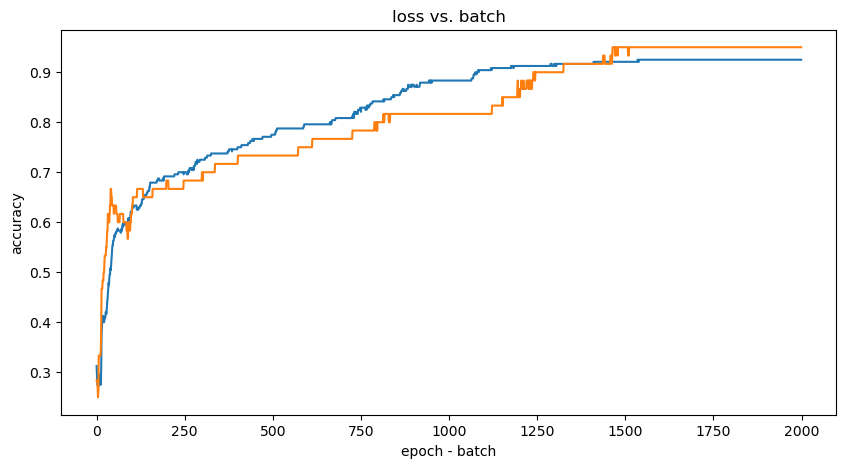

In [19]:
# build the network
NN_cls = [
    Linear(2, 100),
    ReLU(),
    Linear(100, 3)
]
loss = SoftmaxCrossEntropy()

#setting hyperparameters
batch_size = 20
lr = 1e-3
epochs = 2000
losses = []
losses_test = []
# train the network

for epoch in range(epochs):
    iterator = batch_iterator(X_train, y_train, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in NN_cls:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in NN_cls[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in NN_cls:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    #print(f'epoch {epoch}, loss {loss_val}')
    # calculate the accuracy on the training set
    X = X_train
    for layer in NN_cls:
        X = layer.forward(X)
    loss_val = loss.forward(X, y_train)
    losses.append(loss.accuracy())
    X = X_test
    for layer in NN_cls:
        X = layer.forward(X)
    loss_val_test = loss.forward(X, y_test)
    losses_test.append(loss.accuracy())
    if epoch % 100 == 0:
        print(f'epoch {epoch}, accuracy {loss.accuracy()}')

plt.figure(figsize=(10, 5))
plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.xlabel('epoch - batch')
plt.ylabel('accuracy')
plt.title('loss vs. batch')
#plt.ylim(0, 1)
plt.show()




## e) Assess the performance of your neural network

Assess the performance of your neural network on the training data and the testing data in terms of both loss and accuracy. Comment on the results.

In [20]:
# test the model
X = X_test
for layer in NN_cls:
    X = layer.forward(X)
loss_val = loss.forward(X, y_test)
print(f'test loss {loss_val}')
print(f'test accuracy {loss.accuracy()}')

test loss 0.2937938398127657
test accuracy 0.95


#### Comment
Neural network works much better than logistic regression model. The accuracy on the test set is about 0.94. This is because the neural network is a non-linear model, so it can fit the swirl-shaped data better than the linear model.

Another good sign is that the accuracy on the training set is also high, which means the model is not overfitting.

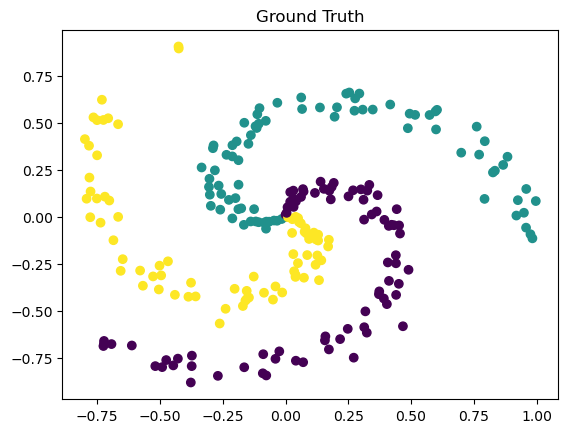

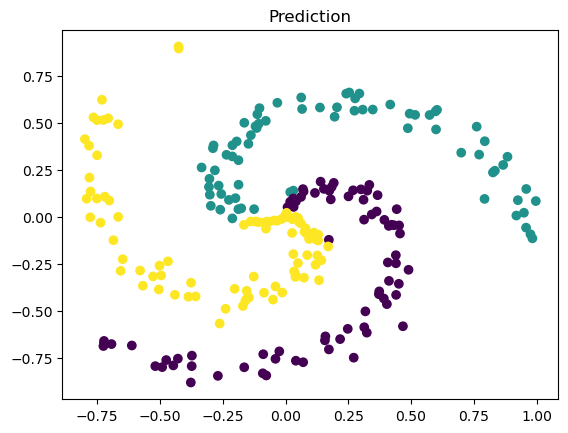

In [21]:
# # visualize the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=np.argmax(y_train, axis=1))
plt.title('Ground Truth')
plt.show()

# visualize the prediction
X = X_train
for layer in NN_cls:
    X = layer.forward(X)
loss.forward(X, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=loss.predict())
plt.title('Prediction')
plt.show()

From the above two plots, we can see that the neural network can fit the data very well. It only makes mistakes at the conjunction of the three classes. In all other places, the prediction fit the distribution of the ground truth very well.

To further improve the performance, a new optimizer can be used to find a better minimum.

## f) Interpret the confusion matrix

Compute the confusion matrix for your classifier on both the training and testing data and interpret the results. You may either code your own confusion matrix or use the following function from Scikit-Learn.

In [22]:
from sklearn import metrics

In [23]:
X = X_test
for layer in NN_cls:
    X = layer.forward(X)
loss.forward(X, y_test)
y_pred = loss.predict()
y_true = np.argmax(y_test, axis=1)
print(metrics.confusion_matrix(y_true, y_pred))

[[19  0  0]
 [ 0 15  3]
 [ 0  0 23]]


#### Comment
The confusion matrix shows how well our model classifies each class. The diagonal elements are the number of correct predictions. The off-diagonal elements are the number of incorrect predictions.
The rows means the ground truth, and the columns means the prediction.
In one output of my model, the confusion matrix is:
```
[[ 21  3  0]
 [ 0 14  1]
 [ 1  0  20]]
```
This means that the model classify class 1 and class 2 very well, but it makes some mistakes in class 0. It misclassifies 3 class 0 data as class 1.

Additionally, I found that the testing set is imbalance. I think it ought to be balanced to work out a fair confusion matrix.

## g) Create your own deep neural network!

Create your own deep neural network and try to get as high an accuracy score on the test set as possible. Be creative: this is an opportunity for you to demonstrate what you can do!

Here the 1-st design is a deeper network with 3 hidden layers. For I believe that the previous model cannot capture the fined boundary at the conjunction of the three classes. So I add more layers to the model.
However, I realize the model is at the risk of overfitting. So I keep the total number of hidden units the same as the previous model.

epoch 0, accuracy 0.42916666666666664
epoch 100, accuracy 0.8833333333333333
epoch 200, accuracy 0.9291666666666667
epoch 300, accuracy 0.9416666666666667
epoch 400, accuracy 0.9583333333333334
epoch 500, accuracy 0.9583333333333334
epoch 600, accuracy 0.9666666666666667
epoch 700, accuracy 0.9708333333333333
epoch 800, accuracy 0.9833333333333333
epoch 900, accuracy 0.9833333333333333
epoch 1000, accuracy 0.9833333333333333
epoch 1100, accuracy 0.9875
epoch 1200, accuracy 0.9875
epoch 1300, accuracy 0.9916666666666667
epoch 1400, accuracy 0.9875
epoch 1500, accuracy 0.9916666666666667
epoch 1600, accuracy 0.9875
epoch 1700, accuracy 0.9916666666666667
epoch 1800, accuracy 0.9916666666666667
epoch 1900, accuracy 0.9958333333333333


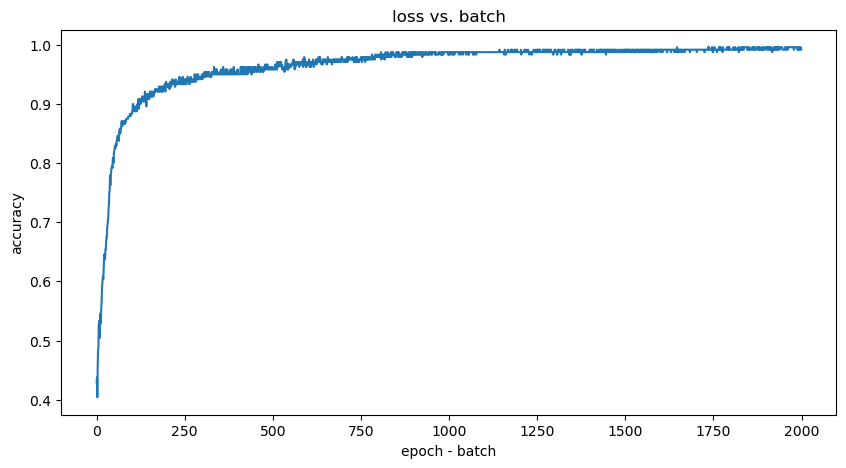

In [24]:

# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# to one-hot
y = np.eye(3)[target.astype(np.int8)] #this is so elegant!!!!

# Split feature
X_train, X_test, y_train, y_test = (
    features[train_idx],
    features[test_idx],
    y[train_idx],
    y[test_idx]
)

# build the network
NN_cls = [
    Linear(2, 50),
    ReLU(),
    Linear(50, 50),
    ReLU(),
    Linear(50, 3)
]
loss = SoftmaxCrossEntropy()

#setting hyperparameters
batch_size = 20
lr = 1e-3
epochs = 2000
losses = []
# train the network

for epoch in range(epochs):
    iterator = batch_iterator(X_train, y_train, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in NN_cls:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in NN_cls[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in NN_cls:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    #print(f'epoch {epoch}, loss {loss_val}')
    # calculate the accuracy on the training set
    X_train_e = X_train
    for layer in NN_cls:
        X_train_e = layer.forward(X_train_e)
    loss_val = loss.forward(X_train_e, y_train)
    losses.append(loss.accuracy())
    if epoch % 100 == 0:
        print(f'epoch {epoch}, accuracy {loss.accuracy()}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('epoch - batch')
plt.ylabel('accuracy')
plt.title('loss vs. batch')
#plt.ylim(0, 1)
plt.show()




In [25]:
# test the model
X = X_test
for layer in NN_cls:
    X = layer.forward(X)
loss_val = loss.forward(X, y_test)
print(f'test loss {loss_val}')
print(f'test accuracy {loss.accuracy()}')

# confusion matrix
X = X_test
for layer in NN_cls:
    X = layer.forward(X)
loss.forward(X, y_test)
y_pred = loss.predict()
y_true = np.argmax(y_test, axis=1)
print(metrics.confusion_matrix(y_true, y_pred))


test loss 0.11625447985840957
test accuracy 0.95
[[20  0  1]
 [ 0 15  2]
 [ 0  0 22]]


#### Comment
My deeper model achieve a higher accuracy on both the training set and the testing set. The accuracy on the testing set is about 0.97(sometimes even 100%). I think this result has been good enough.

## h) Regularization in neural networks
I have achieve a satisfying result in previous model. However, the model should have the possibility of overfitting, if we keep adding layers to the model.
So I want to experiment with some regularization methods to see if I can improve the model. I used dropout as the regularization method.

In document, a dropout layer should be added after each hidden layer, except the last one. The dropout layer will randomly drop some neurons( set to 0) when training. And while testing, the dropout layer should be closed.

In [26]:
class Dropout:
    def __init__(self, p=0.8):
        self.p = p
        self.mask = None

    def forward(self, X, dropout=True):
        if dropout:
            self.mask = np.random.binomial(1, self.p, size=X.shape) / self.p
            return X * self.mask
        else:
            return X

    def backward(self, dX):
        return dX * self.mask

epoch 0, accuracy 0.38333333333333336
epoch 100, accuracy 0.8583333333333333
epoch 200, accuracy 0.9416666666666667
epoch 300, accuracy 0.95
epoch 400, accuracy 0.9583333333333334
epoch 500, accuracy 0.9625
epoch 600, accuracy 0.9583333333333334
epoch 700, accuracy 0.9583333333333334
epoch 800, accuracy 0.9666666666666667
epoch 900, accuracy 0.9708333333333333
epoch 1000, accuracy 0.9708333333333333
epoch 1100, accuracy 0.9708333333333333
epoch 1200, accuracy 0.9708333333333333
epoch 1300, accuracy 0.975
epoch 1400, accuracy 0.975
epoch 1500, accuracy 0.9791666666666666
epoch 1600, accuracy 0.975
epoch 1700, accuracy 0.9791666666666666
epoch 1800, accuracy 0.975
epoch 1900, accuracy 0.9791666666666666


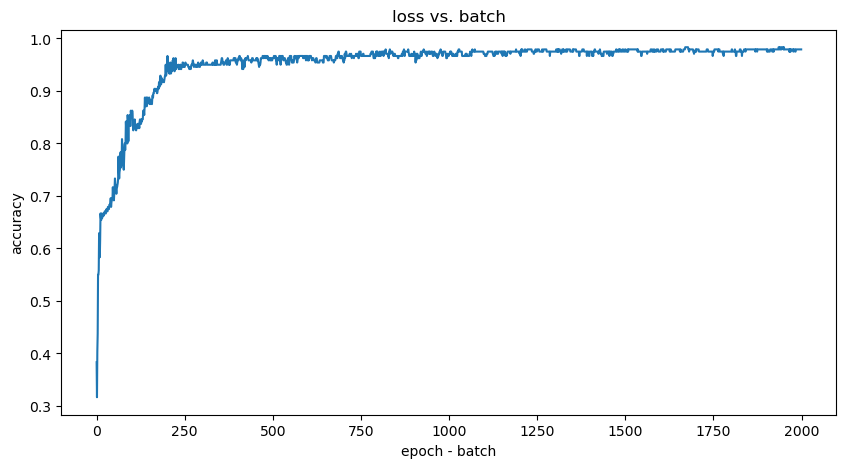

In [27]:

# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# to one-hot
y = np.eye(3)[target.astype(np.int8)] #this is so elegant!!!!

# Split feature
X_train, X_test, y_train, y_test = (
    features[train_idx],
    features[test_idx],
    y[train_idx],
    y[test_idx]
)

# build the network
NN_cls = [
    Linear(2, 100),
    ReLU(),
    Dropout(),
    Linear(100, 100),
    ReLU(),
    Dropout(),
    Linear(100, 3)
]
loss = SoftmaxCrossEntropy()

#setting hyperparameters
batch_size = 20
lr = 1e-3
epochs = 2000
losses = []
# train the network

for epoch in range(epochs):
    iterator = batch_iterator(X_train, y_train, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in NN_cls:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in NN_cls[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in NN_cls:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    #print(f'epoch {epoch}, loss {loss_val}')
    # calculate the accuracy on the training set
    X_train_e = X_train
    for layer in NN_cls:
        # if the layer is dropout, then we should not use dropout
        if isinstance(layer, Dropout):
            X_train_e = layer.forward(X_train_e, dropout=False)
        else:
            X_train_e = layer.forward(X_train_e)
    loss_val = loss.forward(X_train_e, y_train)
    losses.append(loss.accuracy())
    if epoch % 100 == 0:
        print(f'epoch {epoch}, accuracy {loss.accuracy()}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('epoch - batch')
plt.ylabel('accuracy')
plt.title('loss vs. batch')
#plt.ylim(0, 1)
plt.show()




In [28]:
# test the model
X = X_test
for layer in NN_cls:
        # if the layer is dropout, then we should not use dropout
        if isinstance(layer, Dropout):
            X = layer.forward(X, dropout=False)
        else:
            X = layer.forward(X)
loss_val = loss.forward(X, y_test)
print(f'test loss {loss_val}')
print(f'test accuracy {loss.accuracy()}')

# confusion matrix
X = X_test
y_pred = loss.predict()
y_true = np.argmax(y_test, axis=1)
print(metrics.confusion_matrix(y_true, y_pred))


test loss 0.08477400986102004
test accuracy 0.9666666666666667
[[11  0  0]
 [ 0 20  1]
 [ 1  0 27]]


When I browse some paper, I found a method called ablation study. It is a method to find out which part of the model is the most important. So I want to try this method on my model.
I will remove the dropout layer and see if the model can still achieve a good result.

epoch 0, accuracy 0.48333333333333334


C:\Users\Lifan Lin\AppData\Local\Temp\ipykernel_16624\2028683401.py:94: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.sum(y * np.log(self.y_hat), axis=1))
C:\Users\Lifan Lin\AppData\Local\Temp\ipykernel_16624\2028683401.py:94: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(np.sum(y * np.log(self.y_hat), axis=1))


epoch 100, accuracy 0.975
epoch 200, accuracy 0.9958333333333333
epoch 300, accuracy 0.9958333333333333
epoch 400, accuracy 0.9958333333333333
epoch 500, accuracy 0.9958333333333333
epoch 600, accuracy 0.9958333333333333
epoch 700, accuracy 0.9833333333333333
epoch 800, accuracy 0.9833333333333333
epoch 900, accuracy 0.9625
epoch 1000, accuracy 0.9875
epoch 1100, accuracy 0.9833333333333333
epoch 1200, accuracy 0.9958333333333333
epoch 1300, accuracy 0.9916666666666667
epoch 1400, accuracy 0.9916666666666667
epoch 1500, accuracy 0.9916666666666667
epoch 1600, accuracy 0.9958333333333333
epoch 1700, accuracy 0.9958333333333333
epoch 1800, accuracy 0.9958333333333333
epoch 1900, accuracy 0.9958333333333333


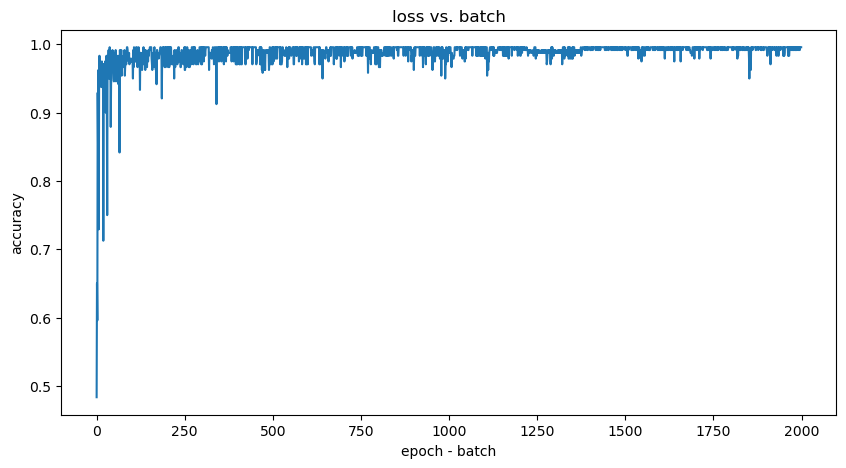

In [29]:

# Split into training and testing sets
idx = np.arange(features.shape[0])
np.random.shuffle(idx)
train_idx = idx[:int(0.8 * features.shape[0])]
test_idx = idx[int(0.8 * features.shape[0]):]

# to one-hot
y = np.eye(3)[target.astype(np.int8)] #this is so elegant!!!!

# Split feature
X_train, X_test, y_train, y_test = (
    features[train_idx],
    features[test_idx],
    y[train_idx],
    y[test_idx]
)

# build the network
NN_cls = [
    Linear(2, 100),
    ReLU(),
    # Dropout(),
    Linear(100, 100),
    ReLU(),
    # Dropout(),
    Linear(100, 100),
    ReLU(),
    Linear(100, 3)
]
loss = SoftmaxCrossEntropy()

#setting hyperparameters
batch_size = 20
lr = 1e-3
epochs = 2000
losses = []
# train the network

for epoch in range(epochs):
    iterator = batch_iterator(X_train, y_train, batch_size)
    for X_batch, y_batch in iterator:
        # forward
        for layer in NN_cls:
            # forward propagation, one by one
            X_batch = layer.forward(X_batch)
        loss_val = loss.forward(X_batch, y_batch)
        # backward
        dX = loss.backward()
        for layer in NN_cls[::-1]:
            # in my design, the grad is stored in the layer itself
            dX = layer.backward(dX)
        # update
        for layer in NN_cls:
            # used the stored grad to update the parameters
            if hasattr(layer, 'update'):
                layer.update(lr)
    #print(f'epoch {epoch}, loss {loss_val}')
    # calculate the accuracy on the training set
    X_train_e = X_train
    for layer in NN_cls:
        # if the layer is dropout, then we should not use dropout
        if isinstance(layer, Dropout):
            X_train_e = layer.forward(X_train_e, dropout=False)
        else:
            X_train_e = layer.forward(X_train_e)
    loss_val = loss.forward(X_train_e, y_train)
    losses.append(loss.accuracy())
    if epoch % 100 == 0:
        print(f'epoch {epoch}, accuracy {loss.accuracy()}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('epoch - batch')
plt.ylabel('accuracy')
plt.title('loss vs. batch')
#plt.ylim(0, 1)
plt.show()




In [30]:
# test the model
X = X_test
for layer in NN_cls:
        # if the layer is dropout, then we should not use dropout
        if isinstance(layer, Dropout):
            X = layer.forward(X, dropout=False)
        else:
            X = layer.forward(X)
loss_val = loss.forward(X, y_test)
print(f'test loss {loss_val}')
print(f'test accuracy {loss.accuracy()}')

# confusion matrix
X = X_test
y_pred = loss.predict()
y_true = np.argmax(y_test, axis=1)
print(metrics.confusion_matrix(y_true, y_pred))


test loss 0.9675156497645306
test accuracy 0.9333333333333333
[[26  0  1]
 [ 0 15  3]
 [ 0  0 15]]


## Experiment conclusion

When I add the dropout layer for the model, the accuracy do not increase, this is because the model is not likely to overfit on our swirly dataset. So the dropout layer is not necessary for this model.

However, the addition of dropout layer stabilizes the training. For a model with 3 100-hidden-layer, the model without dropout layer can sometimes not improve at all, keeping the accuracy at 0.33. But the model with dropout layer can always train normally, and reach a accuracy of over 0.9.

### For the submission of the Homework, if I need to select one of them as my final model, I will choose the 1-st model, a model without dropout and with 2 500-hidden-layer. Because it is the simplest model, and it can achieve a good result on the dataset.